In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score,GridSearchCV

from sklearn import ensemble
import xgboost

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os 
print(os.listdir("../data")) # this will list files in input directory

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'gender_submission.csv']


# Load Data

In [2]:
raw_train=pd.read_csv('../data/train.csv')
raw_test=pd.read_csv('../data/test.csv')

In [3]:
raw_train.info() # So, there are some null in Age, Cabin and Embarked

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
raw_train.tail(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [5]:
raw_test.info() # nulls in Age, Cabin and embarked ( same as train data), here in Fare Also

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
raw_test.tail(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


We are merging data together, so we can process data, after feature engineering we will split 

In [7]:
data=pd.concat([raw_train, raw_test], axis=0).reset_index(drop=True) # concatinating test and train removing index
data.head(2)
data.tail(2) # surviced will be NaN for test data

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1307,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309
1308,NaN,NaN,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668


In [8]:
# nulls in 4 columns -> Age, Embarked, cabin, Fare ( Survived will not count as it will not have value for test data)
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [9]:
data.isnull().sum()  # finding null per column

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

# Visualization & Data Cleaning

### Cabin

In [10]:
data["Cabin"].value_counts()

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
D                  4
B96 B98            4
                  ..
A20                1
B82 B84            1
E17                1
A16                1
A10                1
Name: Cabin, Length: 186, dtype: int64

In [11]:
data["Cabin"].isnull().sum()

1014

In [12]:
# Replace NA as X, kepp initial
data["Cabin"]=data['Cabin'].fillna('X')
data['Cabin']=data['Cabin'].str.get(0)
# cabin number is like 'A01', 'B99' etc. so just keeping first letter to get category so for A01 -> 'A'

In [13]:
data["Cabin"].isnull().sum() # all has been filled

0

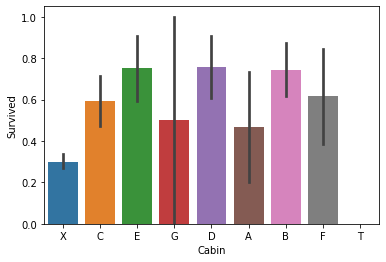

In [14]:
sns.barplot(x="Cabin", y="Survived", data=data) # relation between Cabin and survival

### Embarked

In [15]:
data['Embarked'].isnull().sum()

2

In [16]:
data['Embarked'].value_counts() # embarked - from where, C = Cherbourg, Q = Queenstown, S = Southampton

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [17]:
data[data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


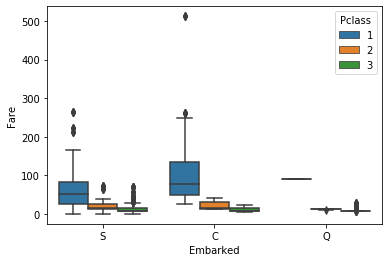

In [18]:
 sns.boxplot(x="Embarked", y="Fare", hue="Pclass",data=data) # relation between Embarked and Fare for each Class


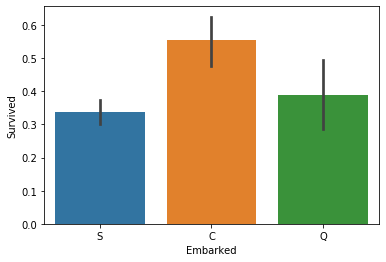

In [19]:
sns.barplot(x='Embarked',y="Survived",data=data)

In [20]:
data['Embarked']=data['Embarked'].fillna('C')

### Fare

In [21]:
data[data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,X,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [22]:
fare=data[(data['Age'] >60) & (data['Embarked'] == "S") & (data['Pclass'] == 3)].Fare # find all fares matching condition
data['Fare']=data['Fare'].fillna(fare.median()) # find media and assign

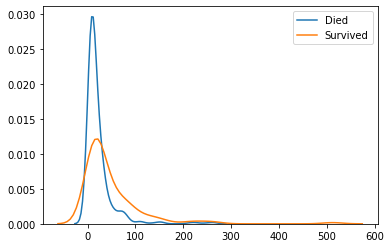

In [23]:
sns.kdeplot(data.loc[data['Survived'] == 0, 'Fare'], label='Died')
sns.kdeplot(data.loc[data['Survived'] == 1, 'Fare'], label='Survived')

### Name

In [24]:
data.Name

0                                 Braund, Mr. Owen Harris
1       Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                  Heikkinen, Miss. Laina
3            Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                                Allen, Mr. William Henry
                              ...                        
1304                                   Spector, Mr. Woolf
1305                         Oliva y Ocana, Dona. Fermina
1306                         Saether, Mr. Simon Sivertsen
1307                                  Ware, Mr. Frederick
1308                             Peter, Master. Michael J
Name: Name, Length: 1309, dtype: object

In [25]:
# Get Title from Name
data["Title"] = data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
data["Title"].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Major             2
Mlle              2
Ms                2
the Countess      1
Dona              1
Mme               1
Jonkheer          1
Sir               1
Capt              1
Lady              1
Don               1
Name: Title, dtype: int64

In [26]:
data["Title"] = data["Title"].replace(['Mlle','Ms'], 'Miss')
data["Title"] = data["Title"].replace(['Mme'], 'Mrs')
data["Title"] = data["Title"].replace(['Rev', 'Dr', 'Col', 'Major', 'Capt'], 'Officer')
data["Title"] = data["Title"].replace(['the Countess', 'Don', 'Lady', 'Sir', 'Jonkheer', 'Dona'], 'Royalty')
data["Title"].value_counts()

Mr         757
Miss       264
Mrs        198
Master      61
Officer     23
Royalty      6
Name: Title, dtype: int64

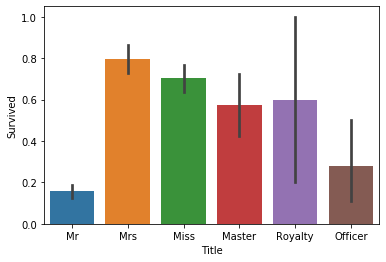

In [27]:
sns.barplot(x="Title", y="Survived", data=data)

### Parch & SibSp

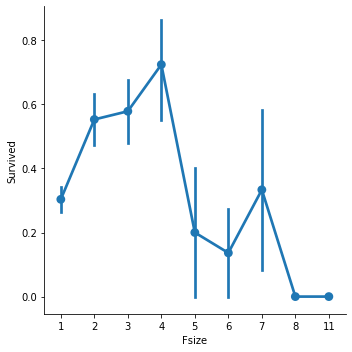

In [28]:
# Create a family size descriptor from SibSp and Parch
data["Fsize"] = data["SibSp"] + data["Parch"] + 1
sns.factorplot(x="Fsize",y="Survived",data = data)

In [29]:
# Create new feature of family size
def Fam_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
data['FamilyLabel']=data['Fsize'].apply(Fam_label)

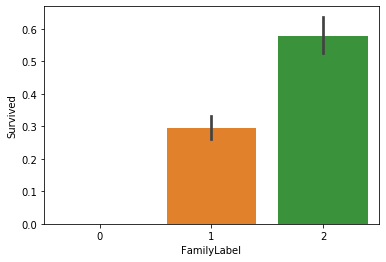

In [30]:
sns.barplot(x="FamilyLabel", y="Survived", data=data)

### Pclass

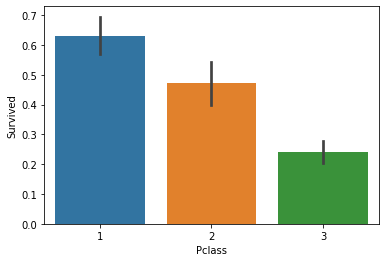

In [31]:
sns.barplot(x="Pclass", y="Survived", data=data)

### Sex

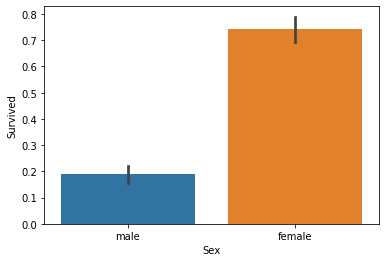

In [32]:
sns.barplot(x="Sex", y="Survived", data=data)

### Ticket

In [33]:
data['Ticket'].value_counts() # ticket sale per ticket type from 1 to 11

CA. 2343            11
1601                 8
CA 2144              8
3101295              7
S.O.C. 14879         7
                    ..
315151               1
A4. 54510            1
368702               1
C.A./SOTON 34068     1
349241               1
Name: Ticket, Length: 929, dtype: int64

In [34]:
Ticket_Count = dict(data['Ticket'].value_counts())
data['TicketGroup'] = data['Ticket'].apply(lambda x:Ticket_Count[x])
data['TicketGroup'].value_counts() # group ticket by count of sales

1     713
2     264
3     147
4      64
7      35
5      35
6      24
8      16
11     11
Name: TicketGroup, dtype: int64

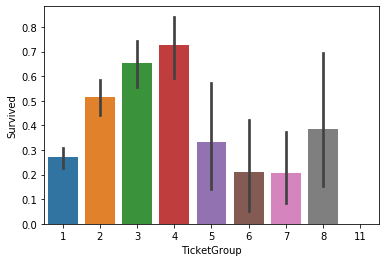

In [35]:
sns.barplot(x='TicketGroup', y='Survived', data=data)

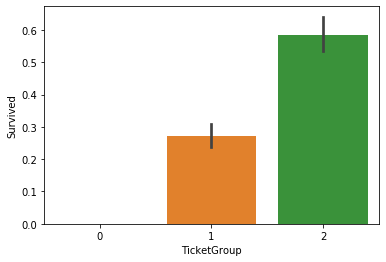

In [36]:
def Ticket_Label(s): # group all having same survival together
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0

data['TicketGroup'] = data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup', y='Survived', data=data)

### Age

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
Age            1046 non-null float64
Cabin          1309 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Title          1309 non-null object
Fsize          1309 non-null int64
FamilyLabel    1309 non-null int64
TicketGroup    1309 non-null int64
dtypes: float64(3), int64(7), object(6)
memory usage: 163.8+ KB


In [38]:
age_df = data[['Age', 'Pclass','Sex','Title','Fsize']]

# get_dummies() only works on strings, and convert to one-hot encoding
# here it will only work on String columns ( Sex(male/female) and title)
age_df=pd.get_dummies(age_df) # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
age_df.head()

,Age,Pclass,Fsize,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,22.0,3,2,0,1,0,0,1,0,0,0
1,38.0,1,2,1,0,0,0,0,1,0,0
2,26.0,3,1,1,0,0,1,0,0,0,0
3,35.0,1,2,1,0,0,0,0,1,0,0
4,35.0,3,1,0,1,0,0,1,0,0,0


In [39]:
age_df[age_df.Age.notnull()].as_matrix()# converts df into 2d matrix/ as below

array([[22. ,  3. ,  2. , ...,  0. ,  0. ,  0. ],
       [38. ,  1. ,  2. , ...,  1. ,  0. ,  0. ],
       [26. ,  3. ,  1. , ...,  0. ,  0. ,  0. ],
       ...,
       [28. ,  3. ,  1. , ...,  0. ,  0. ,  0. ],
       [39. ,  1. ,  1. , ...,  0. ,  0. ,  1. ],
       [38.5,  3. ,  1. , ...,  0. ,  0. ,  0. ]])

In [40]:
known_age = age_df[age_df.Age.notnull()].as_matrix() # Rows with known age
unknown_age = age_df[age_df.Age.isnull()].as_matrix() # Rows with unknown age
y = known_age[:, 0] # age columns
X = known_age[:, 1:] # all other columns
X

array([[3., 2., 0., ..., 0., 0., 0.],
       [1., 2., 1., ..., 1., 0., 0.],
       [3., 1., 1., ..., 0., 0., 0.],
       ...,
       [3., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 1.],
       [3., 1., 0., ..., 0., 0., 0.]])

In [41]:
#predicting ages for unknown using XGBoost
rfr=xgboost.XGBClassifier()
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age[:, 1::])
predictedAges[:10]

array([21., 30., 45., 21., 22., 21., 35., 22., 21., 21.])

In [42]:
data.loc[(data.Age.isnull()), 'Age' ] = predictedAges #put predicted ages where it was null
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Fsize,FamilyLabel,TicketGroup
0,22.0,X,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,2,2,1
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,2,2,2
2,26.0,X,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,1,1,1
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs,2,2,2
4,35.0,X,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr,1,1,1


# Modeling

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
Age            1309 non-null float64
Cabin          1309 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Title          1309 non-null object
Fsize          1309 non-null int64
FamilyLabel    1309 non-null int64
TicketGroup    1309 non-null int64
dtypes: float64(3), int64(7), object(6)
memory usage: 163.8+ KB


In [44]:
data.head(1)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Fsize,FamilyLabel,TicketGroup
0,22.0,X,S,7.25,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,2,2,1


In [45]:
#choosing required columns and converting to 0/1 for strings
data=data[['Survived','Age','Cabin','Embarked','Fare','Pclass','Sex','TicketGroup','FamilyLabel','Title']]
data=pd.get_dummies(data)
data.head()

,Survived,Age,Fare,Pclass,TicketGroup,FamilyLabel,Cabin_A,Cabin_B,Cabin_C,Cabin_D,...,Embarked_Q,Embarked_S,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,0.0,22.0,7.2500,3,1,2,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
1,1.0,38.0,71.2833,1,2,2,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
2,1.0,26.0,7.9250,3,1,1,0,0,0,0,...,0,1,1,0,0,1,0,0,0,0
3,1.0,35.0,53.1000,1,2,2,0,0,1,0,...,0,1,1,0,0,0,0,1,0,0
4,0.0,35.0,8.0500,3,1,1,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0


In [46]:
data.tail()

,Survived,Age,Fare,Pclass,TicketGroup,FamilyLabel,Cabin_A,Cabin_B,Cabin_C,Cabin_D,...,Embarked_Q,Embarked_S,Sex_female,Sex_male,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
1304,NaN,21.0,8.0500,3,1,1,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
1305,NaN,39.0,108.9000,1,2,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
1306,NaN,38.5,7.2500,3,1,1,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
1307,NaN,21.0,8.0500,3,1,1,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
1308,NaN,9.0,22.3583,3,2,2,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 26 columns):
Survived         891 non-null float64
Age              1309 non-null float64
Fare             1309 non-null float64
Pclass           1309 non-null int64
TicketGroup      1309 non-null int64
FamilyLabel      1309 non-null int64
Cabin_A          1309 non-null uint8
Cabin_B          1309 non-null uint8
Cabin_C          1309 non-null uint8
Cabin_D          1309 non-null uint8
Cabin_E          1309 non-null uint8
Cabin_F          1309 non-null uint8
Cabin_G          1309 non-null uint8
Cabin_T          1309 non-null uint8
Cabin_X          1309 non-null uint8
Embarked_C       1309 non-null uint8
Embarked_Q       1309 non-null uint8
Embarked_S       1309 non-null uint8
Sex_female       1309 non-null uint8
Sex_male         1309 non-null uint8
Title_Master     1309 non-null uint8
Title_Miss       1309 non-null uint8
Title_Mr         1309 non-null uint8
Title_Mrs        1309 non-null uint8


In [52]:
train=data[:len(raw_train)] # take train data
test=data[len(raw_train):].drop(['Survived'],axis=1) # take test data
X = train.drop(['Survived'],axis=1)
y = train.Survived

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [61]:
model = ensemble.RandomForestClassifier(random_state = 5, 
                                      warm_start = True,
                                      n_estimators = 26, 
                                      max_depth = 6, 
                                      max_features = 'sqrt')
clf = model.fit(X_train,y_train)
clf.score(X_test,y_test)

0.84593837535014

In [65]:
predictions = model.predict(test)
submission = pd.DataFrame({"PassengerId": raw_test["PassengerId"],
                           "Survived": predictions.astype(np.int32)})
submission.to_csv("../output/output.csv", index=False)
